In [72]:
import networkx as nx
import osmnx as ox
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import shapely
import random
import numpy as np
from IPython.display import clear_output
#from mas_transportation_utils import all_paths

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.0.1'

### UNITES
1 TICK = 1 SECONDE

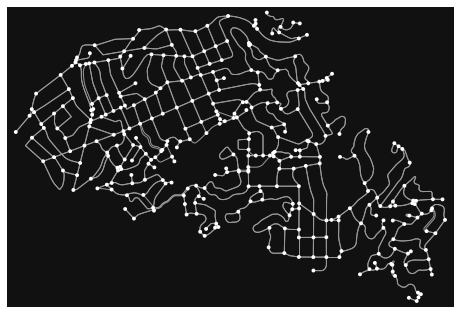

In [37]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive') 
fig, ax = ox.plot_graph(G)
hwy_speeds = {'residential': 30,
              'secondary': 50,
              'tertiary': 70}
G = ox.add_edge_speeds(G, hwy_speeds)
#temps arrondis
G = ox.add_edge_travel_times(G, precision=0)
#temps non arrondis
#G = ox.add_edge_travel_times(G)

####
# #arrondi les longueurs de routes pour eviter les décimales
####PLUS SIMPLE : G = ox.add_edge_travel_times(G, precision=0)
# G.edges()
# for edge in list(G.edges()):
#     for e in G.get_edge_data(edge[0], edge[1]).values():
#         e['travel_time'] = round(e['travel_time'])
    

In [38]:
G.get_edge_data(53017091, 53064327)

{0: {'osmid': 6345781,
  'name': 'Rose Avenue',
  'highway': 'residential',
  'oneway': False,
  'length': 231.335,
  'speed_kph': 30.0,
  'travel_time': 28.0}}

In [64]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None: 
        pass
    
    def decide(self) -> None:
        pass
    
class UserAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        
        #calcul de la longueur du plus court chemin à l'origine
        ###self.SPL = nx.shortest_path_length(sma.G, source=self.v_dep, target=self.v_arr)
        
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass
    
class ContinuousDriverAgent(UserAgent):
    '''pref might be : "length" or "travel_time"'''
    def __init__(self, unique_id, v_dep, v_arr, capacity=3, detour_factor=0, pref_weight='length', test=False):
        super().__init__(unique_id, v_dep, v_arr)
        
        self.pref_weight = pref_weight
        self.detour_factor = detour_factor
        self.SP = ox.shortest_path(sma.G, self.v_dep, self.v_arr, weight=pref_weight)
        self.SPL = nx.shortest_path_length(sma.G, self.v_dep, self.v_arr, weight=pref_weight)
        self.detour_factor = detour_factor
        
        self.trip = self.SP
        self.v_r = self.v_dep
        
        self.current_pos = dict()
        self.current_pos['node1'] = self.v_dep
        self.current_pos['node2'] = self.v_dep
        self.current_pos['edge_data'] = {'travel_time':0}
        self.current_pos['time'] = 0
        
        self.c = capacity
        self.l_arr_time = sma.tick + self.SPL + (self.SPL*detour_factor)
        
        #tableaux du scheduling S
        self.arr = [self.SPL] #tableau des premières arrivées
        self.ddl = [self.l_arr_time] #tableau des dernières arrivées
        self.slk = [self.ddl[0]-self.arr[0]] #tableau de la marge de temps a chaque étape
        
        self.stops = [v_arr] #tableau référençant les noeuds avec arrêts obligatoire 
                             #(noeuds de recup et de dépot des passagers et noeud d'arrivé du conducteur)
        self.capacities = [capacity]
        self.tag_event = False
        
        self.perceptions = [] #les ellipses, la perception à chaque étape
        self.perceptions.append(self.get_perception(self.v_dep, self.v_arr, 
                                                                self.l_arr_time - sma.tick))
        
        #affichage de la progression sur une carte
        self.test = test
        if self.test :
            fig, ax = ox.plot_graph_route(sma.G, self.trip, route_color='y', route_linewidth=6, node_size=0)

    
    def add_rider_to_scheduler(self, rider, r_v1, r_v2, dl_v1, dl_v2):
        '''A terme deviendra surement une verif avant modification, donc avec un return'''
        #on ajoute le passager au scheduler, on met a jour le trip et la capacité
        
        #########checks##############
        if dl_v1 > self.ddl[-1] or dl_v2 > self.ddl[-1]:
            raise Exception("Rider's deadline should be lower than driver's deadline, subject to change")
            
        driver_scope = set([item for sublist in self.perceptions for item in sublist])
        if r_v1 not in driver_scope or r_v2 not in driver_scope:
            raise Exception("Rider's nodes should be in the driver's scope")
        #############################    
            
        for i in range(len(self.ddl)) :
            if dl_v1 <= self.ddl[i] :
                self.ddl.insert(i, dl_v1)
                self.stops.insert(i, r_v1)
                if i == 0:
                    self.capacities.insert(i, self.c - 1)
                else : 
                    self.capacities.insert(i, self.capacities[i-1]-1)
                for j in range(len(self.ddl[i:])):
                    if dl_v2 <= self.ddl[j] :
                        self.ddl.insert(j, dl_v2)
                        self.stops.insert(j, r_v2)
                        self.capacities.insert(j, self.capacities[i-1]+1)
                        break
                break
                
        #puis on recalcule le chemin le plus court et la marge (skl = slack time)
        
        #pour le premier on se base sur le noeud courant
        self.arr = []
        dif = []
        
        self.arr.append(sma.tick + (self.current_pos['edge_data']['travel_time'] - self.current_pos['time']) + nx.shortest_path_length(sma.G, self.v_r, self.stops[0], weight=self.pref_weight))
        dif.append(self.ddl[0] - self.arr[0])
        
        for i in range(len(self.stops)-1):
            self.arr.append(self.arr[i] + nx.shortest_path_length(sma.G, self.stops[i], self.stops[i+1], weight=self.pref_weight))
            dif.append(self.ddl[i+1] - self.arr[i+1])
        
        #calcul marge dépendante des marges suivantes
        self.slk = []
        for i in range(len(dif)):
            self.slk.append(np.min(dif[i:]))
        
        self.tag_event = True
    
    def get_all_perceptions(self):
        self.perceptions = []
        self.perceptions.append(self.get_perception(self.v_r, self.stops[0],
                                                           (self.arr[0] - sma.tick) + self.slk[0]))
            
        for i in range(len(self.stops)-1):
            self.perceptions.append(self.get_perception(self.stops[i], self.stops[i+1], 
                                                               (self.arr[i+1] - sma.tick - self.arr[i]) + self.slk[i+1]))
    def get_perception(self, orig, dest, max_weight):
        visited = []
        perception = set()
        current_node = orig
        self.algo_recu_percep(current_node, visited, perception, max_weight)
        return perception
    
    def get_perception_set_node(self):
        return set([item for sublist in self.perceptions for item in sublist])
    
    def algo_recu_percep(self, current_node, visited, perception, max_weight):
        for succ in G.neighbors(current_node):
            if succ not in visited :
                visited.append(succ)
                try: 
                    if nx.shortest_path_length(sma.G, orig, succ, weight=self.pref_weight) + nx.shortest_path_length(sma.G, succ, dest, weight=self.pref_weight) <= max_weight:
                        perception.add(succ)
                        self.algo_recu_percep(succ, visited, perception, max_weight)
                except (KeyError, nx.NetworkXNoPath):
                    pass
            
    def update(self): 
        #a terme, il faudra identifiquer dans quelles ellipses sont les modifs et modif uniquement là
        if self.tag_event == True:
            self.get_all_perceptions()
            self.trip = ox.shortest_path(sma.G, self.v_r, self.stops[0], weight=self.pref_weight)
            self.tag_event = False
        else : 
            self.perceptions[0] = self.get_perception(self.v_r, self.stops[0],
                                                           (self.arr[0] - sma.tick) + self.slk[0])
        
        #le conducteur informe l'agent TSA de sa perception, l'agent blackboard
        #pour le moment un seul TSA, on verra plus tard si on en mets plusieurs
        #il faudra alors pour chaque noeud de la perception identifier le TSA responsable
        sma.getTSAs()[0].update_driver_data(self)
        pass
    
    def decide(self):
        current_time = self.current_pos['time'] + 1
        if current_time < self.current_pos['edge_data']['travel_time']:
            self.current_pos['time'] = current_time
            
        else :
            if self.trip[1] == self.v_arr :
                if self.test :
                    clear_output(wait=True)
                    fig, ax = ox.plot_graph_route(sma.G, [self.trip[-1]], route_color='y', route_linewidth=6, node_size=0)
                    
                self.is_alive = False
                sma.getTSAs()[0].update_driver_data(self)
                if sma.verbose == True:
                    print("Driver",self.unique_id,"arrived")
                
            else :
                if sma.verbose == True:
                    print("Driver",self.unique_id,"passing through node",self.current_pos['node2'])
                if self.test :
                    clear_output(wait=True)
                    fig, ax = ox.plot_graph_route(sma.G, self.trip, route_color='y', route_linewidth=6, node_size=0)
                reste = current_time - self.current_pos['edge_data']['travel_time']
                
                
                if self.trip[1] == self.stops[0]:
                    self.arr.pop(0)
                    self.slk.pop(0)
                    self.ddl.pop(0)
                    self.capacities.pop(0)
                    self.perceptions.pop(0)
                    self.stops.pop(0)
                    self.trip = ox.shortest_path(sma.G, self.v_r, self.stops[0],weight=self.pref_weight)
                    
                    
                self.current_pos = dict()
                self.current_pos['node1'] = self.trip.pop(0)
                self.current_pos['node2'] = self.trip[0]
                #print(self.current_pos['node1'], self.current_pos['node2'])
                #print(sma.G.get_edge_data(self.current_pos['node1'], self.current_pos['node2']))
                self.current_pos['edge_data'] = sma.G.get_edge_data(self.current_pos['node1'], self.current_pos['node2'])[0]
                self.current_pos['time'] = reste
                
                
                self.v_r = self.current_pos['node2']
                
                
                
                
    
        ###################################################################
        #sinon il faut determiner si le conducteur est arrivé à destination ou si c'est la fin d'une étape        
#         else :
#             if self.trip[0] == self.v_arr :
#                 self.is_alive = False
#                 sma.getTSAs()[0].update_driver_data(self)
#                 if sma.verbose == True:
#                     print("Driver",self.unique_id,"arrived")
#             else :
#                 if sma.verbose == True:
#                     print("Driver",self.unique_id,"move from",self.v_r,"to",self.trip[0])
#                 self.v_r = self.trip[0]
#                 self.arr.pop(0)
#                 self.slk.pop(0)
#                 self.ddl.pop(0)
#                 self.capacities.pop(0)
#                 self.node_ranges.pop(0)
#                 self.stops.pop(0)
#                 self.trip = nx.shortest_path(sma.G, self.v_r, self.stops[0])[1:]
        

In [ ]:
{'travel_time':0}

In [40]:
class SMA:
    def __init__(self, verbose=False):
        self.tick=0
        self.resetTicks()
        
        self.agentTypeIdDict = {}
        self.agentTypeIdDict["drivers"] = []
        self.agentTypeIdDict["riders"] = []
        self.agentTypeIdDict["tsas"] = []
        self.agentTypeIdDict["tgas"] = []
        
        self.agentDict = {}
        
        self.G = None
        self.verbose = verbose

    def resetTicks(self):
        self.tick=0
          
    def setRoadGraph(self,graph):
        self.G = graph
        
    def addAgent(self,ag):
        self.agentDict[ag.unique_id] = ag
        if "RiderAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["riders"].append(ag.unique_id)
        elif "DriverAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["drivers"].append(ag.unique_id)
        elif "TransportServiceAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tsas"].append(ag.unique_id)
        elif "TransportGeneratorAgent" in ag.__class__.__name__:
            self.agentTypeIdDict["tgas"].append(ag.unique_id)
        else: raise Exception(ag.__class__.__name__,"is a wrong type of agent.")
            
            
    def getAgentFromId(self, unique_id):
        return self.agentDict[unique_id]
    
    def getRiders(self):
        R = []
        for r in self.agentTypeIdDict['riders']:
            R.append(self.agentDict[r])
        return R
        
    def getDrivers(self):
        D = []
        for d in self.agentTypeIdDict['drivers']:
            D.append(self.agentDict[d])
        return D
        
    def getTSAs(self):
        TSA = []
        for tsa in self.agentTypeIdDict['tsas']:
            TSA.append(self.agentDict[tsa])
        return TSA
    
    def getTGAs(self):
        TGA = []
        for tga in self.agentTypeIdDict['tgas']:
            TGA.append(self.agentDict[tga])
        return TGA
        
 
    def run(self,rounds=None):
        if rounds==None:
            #on s'arrete si tout les passagers ou tout les conducteurs sont arrivés
            self.runOnce()
            while len([agent for agent in sma.agentDict.values() if ("RiderAgent" in agent.__class__.__name__)]) > 0 and len([agent for agent in sma.agentDict.values() if ("DriverAgent" in agent.__class__.__name__)]) > 0:
                self.runOnce()
            #print("Finished in",self.tick,"ticks")
        
        else :
            #génération classique
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick+=1
        #random.shuffle(self.agentList)
        for ag in self.agentDict.values() :
            #print(ag.unique_id)
            ag.update()
            ag.decide()
        
        #phase de nettoyage des agents morts
        for ag in self.agentDict.copy().values():
            if ag.is_alive == False:
                if "RiderAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["riders"].removre(ag.unique_id)
                elif "DriverAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["drivers"].remove(ag.unique_id)
                elif "TransportServiceAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tsas"].remove(ag.unique_id)
                elif "TransportGeneratorAgent" in ag.__class__.__name__:
                    self.agentTypeIdDict["tgas"].remove(ag.unique_id)
                else: raise Exception(ag.__class__.__name__,"is a wrong type of agent, even if diying.")
                
                self.agentDict.pop(ag.unique_id)
                
                
        if self.verbose == True:      
            print("tick",str(self.tick),"ended")

In [41]:
class TransportServiceAgent(Agent):
    #tsa : agent blackboard
    def __init__(self, unique_id):
        super().__init__(unique_id)
        self.nodes_to_drivers = dict()
        for node in list(sma.G.nodes):
            self.nodes_to_drivers[node] = set()
        self.drivers_to_nodes = dict()
        
    
     
    def update_driver_data(self, d):
        if d.is_alive == False:
            for node in self.drivers_to_nodes[d]:
                self.nodes_to_drivers[node].remove(d)
            del self.drivers_to_nodes[d]
            
        else :
            node_set = set([item for sublist in d.perceptions for item in sublist])
            #print("node set",node_set)
            #print("d nodes ranges",d.perceptions)
            if d in self.drivers_to_nodes.keys() :
                #noeuds à retirer
                old_nodes = self.drivers_to_nodes[d] - node_set
                #noeuds à ajouter
                new_nodes = node_set - self.drivers_to_nodes[d]

                for old_node in old_nodes:
                    self.nodes_to_drivers[old_node].remove(d)

                for new_node in new_nodes:
                    self.nodes_to_drivers[new_node].add(d)
            else :
                for node in node_set:
                    self.nodes_to_drivers[node].add(d)


            self.drivers_to_nodes[d] = node_set
            
    def get_drivers_from_node(self, node):
        
        return self.nodes_to_drivers[node]
    
    def get_nodes_from_driver(self,driver):
        
        return self.drivers_to_nodes[driver]
    
    def update(self):
        #print("nodes to drivers",self.nodes_to_drivers)
        #print("drivers to nodes",self.drivers_to_nodes)
        pass
    
    def decide(self):
        pass

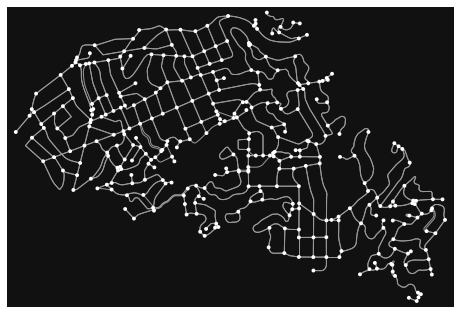

In [42]:
# download/model a street network for some city then visualize it
G = ox.graph_from_place('Piedmont, California, USA', network_type='drive') 
fig, ax = ox.plot_graph(G)
hwy_speeds = {'residential': 30,
              'secondary': 50,
              'tertiary': 70}
G = ox.add_edge_speeds(G, hwy_speeds)

#temps arrondis
G = ox.add_edge_travel_times(G, precision=0)

    

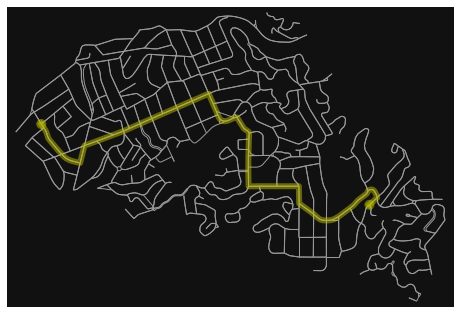

In [88]:
rounds = 50
sma = SMA()
sma.setRoadGraph(G)
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
tsa1 = TransportServiceAgent(1)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=True)


In [89]:
#d1.trip

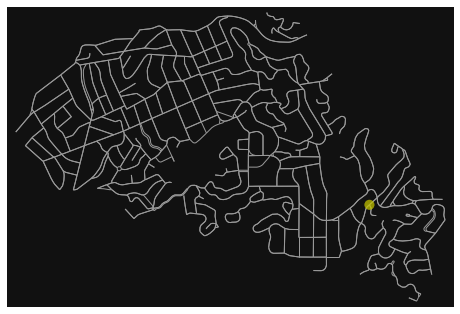

In [92]:
rounds = 50
sma = SMA()
sma.setRoadGraph(G)
sma.tick = 0
orig = list(G)[1]
dest = list(G)[120]
#d1 = ContinuousDriverAgent(1, orig, dest, detour=0.5, pref_weight='length',test=True)
tsa1 = TransportServiceAgent(1)
d1 = ContinuousDriverAgent(2, orig, dest, detour_factor=0.5, pref_weight='travel_time',test=True)

sma.addAgent(tsa1)
sma.addAgent(d1)

for _ in range(rounds):
    sma.runOnce()
    
r1, r2 = random.sample(d1.get_perception_set_node(),2)

d1.add_rider_to_scheduler(None,  r1, r2, 60, 100)

for _ in range(10000):
    sma.runOnce()

In [ ]:
# SPL = nx.shortest_path_length(sma.G, orig, dest, weight='length')
# sub_g_orig = ox.truncate.truncate_graph_dist(sma.G, orig, max_dist=SPL/4, weight='length', retain_all=True)
# #fig, ax = ox.plot_graph(sub_g)

# sub_g_dest = ox.truncate.truncate_graph_dist(sma.G, dest, max_dist=SPL/4, weight='length', retain_all=True)
# #fig, ax = ox.plot_graph(sub_g)

# ec = ['b' if ((u,v) in sub_g_orig.edges() or (u,v) in sub_g_dest.edges()) else 'r' for u, v, k in sma.G.edges(keys=True)]

# fig, ax = ox.plot_graph(sma.G, node_color='w', node_edgecolor='k', node_size=30, 
#                            node_zorder=3, edge_color=ec, edge_linewidth=3)

In [ ]:

orig = list(G)[1]
dest = list(G)[120]
weight='travel_time'
SPL = nx.shortest_path_length(sma.G, orig, dest, weight=weight)
coef_det = 0.2
det = SPL + (SPL*coef_det)


def get_perception(self, orig, dest, max_weight):
    visited = []
    perception = []
    current_node = orig
    self.algo_recu(current_node)
    return perception

def algo_recu(self, current_node):
    for succ in G.neighbors(current_node):
        if succ not in visited :
            visited.append(succ)
            try: 
                if nx.shortest_path_length(sma.G, orig, succ, weight=self.pref_weight) + nx.shortest_path_length(sma.G, succ, dest, weight=pref_weight) <= max_weight:
                    perception.append(succ)
                    self.algo_recu(succ)
            except (KeyError, nx.NetworkXNoPath):
                pass
            
        


In [ ]:
nc = ['b' if (v in perception) else 'w' for v in sma.G.nodes()]

fig, ax = ox.plot_graph(sma.G, node_color=nc, node_edgecolor='k', node_size=30, 
                           node_zorder=3, edge_color='w', edge_linewidth=3)

In [ ]:
routes = ox.k_shortest_paths(G, orig, dest, k=2, weight='length')
fig, ax = ox.plot_graph_routes(G, list(routes), route_colors='y', route_linewidth=4, node_size=0)


In [ ]:
'''Faire ce quil y a au dessus mais pour chaque noeuds composant le shortest trip ? AVEC SLK''' 

In [ ]:
ellipse = ((0, 0),(7, 4),36)

# Let create a circle of radius 1 around center point:
circ = shapely.geometry.Point(ellipse[0]).buffer(1)

# Let create the ellipse along x and y:
ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (clockwise, x axis pointing right):
ellr = shapely.affinity.rotate(ell,ellipse[2])

# If one need to rotate it clockwise along an upward pointing x axis:
elrv = shapely.affinity.rotate(ell,90-ellipse[2])

In [ ]:
from matplotlib import pyplot
from shapely.geometry.point import Point
import shapely.affinity
from descartes import PolygonPatch
# Note: download figures.py manually from shapely github repo, put it in shapely install directory
from shapely.figures import SIZE, GREEN, GRAY, set_limits


# 1st elem = center point (x,y) coordinates
# 2nd elem = the two semi-axis values (along x, along y)
# 3rd elem = angle in degrees between x-axis of the Cartesian base
#            and the corresponding semi-axis
ellipse = ((0, 0),(7, 4),36)

# Let create a circle of radius 1 around center point:
circ = shapely.geometry.Point(ellipse[0]).buffer(1)

# Let create the ellipse along x and y:
ell  = shapely.affinity.scale(circ, int(ellipse[1][0]), int(ellipse[1][1]))

# Let rotate the ellipse (clockwise, x axis pointing right):
ellr = shapely.affinity.rotate(ell,ellipse[2])

# If one need to rotate it clockwise along an upward pointing x axis:
elrv = shapely.affinity.rotate(ell,90-ellipse[2])
# According to the man, a positive value means a anti-clockwise angle,
# and a negative one a clockwise angle.


fig = pyplot.figure()
ax = fig.add_subplot(111)
patch = PolygonPatch(elrv, fc=GREEN, ec=GRAY, alpha=0.5, zorder=2)
ax.add_patch(patch)
set_limits(ax, -10, 10, -10, 10)
pyplot.show()

In [ ]:
def my_all_paths(G, source, target, weight_name, w):
    cutoff = len(G)-1
    visited = [source]
    stack = [iter(G[source])]
    weight = 0
    while stack:
        children = stack[-1]
        child = next(children, None)
        if child is None:
            stack.pop()
            visited.pop()
        elif len(visited) < cutoff:
            if child == target:
                if (visited[-1],child) in G.edges():
                    temp = G[visited[-1]][child][0][weight_name]
                else:
                    temp = G[child][visited[-1]][0][weight_name]
                if weight+temp <= w:
                    yield visited + [target]
            elif child not in visited:
                if (visited[-1],child) in G.edges():
                    weight += G[visited[-1]][child][0][weight_name]
                else:
                    weight += G[child][visited[-1]][0][weight_name]
                visited.append(child)
                stack.append(iter(G[child]))
        else: 
            if child == target or target in children:
                if (visited[-1],child) in G.edges():
                    temp = G[visited[-1]][child][0][weight_name]
                else:
                    temp = G[child][visited[-1]][0][weight_name]
                if weight+temp <= w:
                    yield visited + [target]
            stack.pop()
            visited.pop()

In [ ]:
def get_perception(G, source, target, weight_name, w):
    SPL = nx.shortest_path_length(G, source, target,  weight='length'))

In [ ]:
SP =  nx.shortest_path_length(sma.G, orig, dest, weight='length')
paths = list(nx.all_simple_paths(sma.G, orig, dest, cutoff=10))
#paths = list(my_all_paths(sma.G, source=orig, target=dest, weight_name='length', w=10))
        #return set([item for sublist in paths for item in sublist])

In [ ]:
a = nx.johnson(sma.G, weight='length')
a[0]

In [ ]:
len(G.nodes())

In [ ]:
sma.addAgent(d1)
for _ in range(rounds):
    sma.runOnce()